Integrantes: Francisco Arizola

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

#To read data from R
!pip install pyreadr
import pyreadr

#Hdmpy
import sys
sys.path.insert(0, r"C:\Users\Franc\Python_ML\hdmpy")
import hdmpy

# Potential outcomes and RCTs

## Multiconilearity

Multicollinearity occurs when two or more predictors in a regression model are highly correlated. 
This correlation makes it difficult to isolate the individual effects of each predictor on the response variable. 
It generally results in unstable parameter estimates in the regression, making it tricky to interpret the model.

### Examples and Equation

Consider a multiple regression scenario where we are trying to predict the outcome $ Y $ based on variables $ X_1, X_2,  $ and $ X_3 $. The model can be expressed as:

$$ Y = \beta_0 + \beta_1X_1 + \beta_2X_2 + \beta_3X_3 + \epsilon $$
Where:
- $ \beta_0 $ is the intercept,
- $ \beta_1, \beta_2, \beta_3 $ are coefficients,
- $ \epsilon $ is the error term.

If $ X_1 $ and $ X_2 $ are highly correlated, then changes in $ X_1 $ could be associated with changes in $ X_2 $, making it difficult to separate their individual effects on $ Y $.

### Example of Multicollinearity

#### Scenario

Imagine a study intended to explore factors influencing the success of startup companies, where:
- $ X_1 $ is the total funding received from investors,
- $ X_2 $ is the number of funding rounds,
- $ X_3 $ is the total number of employees.

#### Issue

In such scenarios, the total funding $ X_1 $ and the number of funding rounds $ X_2 $ could be highly correlated because startups often receive more funds as they go through more rounds of funding. This multicollinearity can make it difficult to determine whether the amount of funding or the number of funding rounds has a more significant impact on the success of the startup.

### Consequences

- **Increased Variance**: The standard errors of the coefficients $ \beta_1 $ and $ \beta_2 $ become inflated, which may lead to broader confidence intervals and less reliable statistical tests.
- **Impaired Coefficient Interpretation**: It becomes challenging to parse out which variable between $ X_1 $ and $ X_2 $ contributes more to startup success, as they both share information that could be overlapping in the model.

This example underscores how multicollinearity can obscure the interpretation of variables in a regression model, emphasizing the importance of diagnosing and mitigating it in analytical studies.

In [2]:
# Set the seed
np.random.seed(0)

# Create a 10x10 matrix with the first 9 columns following a normal distribution
matrix = np.random.normal(0, 1, (10, 9))  # Normal distribution with mean 0 and standard deviation 1

# Add a 10th column as a linear combination of three other columns (In this case, we used 1st, 3rd, and 5th)
# The linear combination can be defined as: col_10 = col_1 + 2 * col_3 + 3 * col_5
linear_combination = matrix[:, 0] + 2 * matrix[:, 2] + 3 * matrix[:, 4]
matrix = np.column_stack((matrix, linear_combination))

# Print matrix
print("First five observations of the matrix:")
print(matrix[:5, :])

# Try to find the inverse of the matrix
try:
    inverse = np.linalg.inv(matrix)
    print("Inverse calculated successfully")
    print(inverse[:5, :])
except np.linalg.LinAlgError:
    print("Inverse cannot be calculated")

First five observations of the matrix:
[[ 1.76405235  0.40015721  0.97873798  2.2408932   1.86755799 -0.97727788
   0.95008842 -0.15135721 -0.10321885  9.32420228]
 [ 0.4105985   0.14404357  1.45427351  0.76103773  0.12167502  0.44386323
   0.33367433  1.49407907 -0.20515826  3.68417057]
 [ 0.3130677  -0.85409574 -2.55298982  0.6536186   0.8644362  -0.74216502
   2.26975462 -1.45436567  0.04575852 -2.19960333]
 [-0.18718385  1.53277921  1.46935877  0.15494743  0.37816252 -0.88778575
  -1.98079647 -0.34791215  0.15634897  3.88602125]
 [ 1.23029068  1.20237985 -0.38732682 -0.30230275 -1.04855297 -1.42001794
  -1.70627019  1.9507754  -0.50965218 -2.69002185]]
Inverse calculated successfully
[[-1.01704351e+15  1.52692635e+15  1.18050254e+15  1.19993169e+15
   8.18203205e+13  2.75725750e+14 -4.57057992e+14 -3.48151089e+14
   1.97833276e+14  2.25372013e+14]
 [ 8.77845194e-01 -1.63689907e+00 -1.51004740e+00 -1.22419455e+00
   1.02372773e+00  1.71941842e+00  5.14368491e-01 -8.91416336e-01
  -2

### Observations
Although multicollinearity doesn't inherently lead to different results across programming languages, it can exacerbate the effects of numerical precision issues and computational methods. In a matrix with multicollinearity, small changes in values can lead to large swings in results due to unstable parameter estimates or high condition numbers. This can lead to:

Higher Variance in Estimates: Multicollinearity increases the variance in regression coefficients, making them more sensitive to minor changes in data or computational methods.
Matrix Singularity: Inverting a matrix with high multicollinearity can lead to singularity or near-singularity, which may be handled differently by Python, R, and Julia.

# Analyzing RCT data with Precision Adjustment

### Data
In this lab, we analyze the Pennsylvania re-employment bonus experiment, which was previously studied in "Sequential testing of duration data: the case of the Pennsylvania ‘reemployment bonus’ experiment" (Bilias, 2000), among others. These experiments were conducted in the 1980s by the U.S. Department of Labor to test the incentive effects of alternative compensation schemes for unemployment insurance (UI). In these experiments, UI claimants were randomly assigned either to a control group or one of five treatment groups. Actually, there are six treatment groups in the experiments.Here we focus on treatment group 2. Individuals in the treatment groups were offered a cash bonus if they found a job within some pre-specified period of time (qualification period), provided that the job was retained for a specified duration. The treatments differed in the level of the bonus, the length of the qualification period, and whether the bonus was declining over time in the qualification period.

In [3]:
## loading the data
Penn = pd.read_csv("../Documentos/Github/CausalAI-Course/data/penn_jae.dat" , sep='\s', engine='python')
n = Penn.shape[0]
p_1 = Penn.shape[1]

## We keep the treatment group n°2
Penn = Penn[ (Penn['tg'] == 2) | (Penn['tg'] == 0) ]

Penn.head()

,abdt,tg,inuidur1,inuidur2,female,black,hispanic,othrace,dep,q1,...,q5,q6,recall,agelt35,agegt54,durable,nondurable,lusd,husd,muld
0,10824,0,18,18,0,0,0,0,2,0,...,0,0,0,0,0,0,0,1,0,NaN
1,10635,2,7,3,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,NaN
3,10824,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,NaN
4,10747,0,27,27,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,NaN
9,10754,2,20,20,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,NaN


In [4]:
Penn.shape

(5782, 24)

In [5]:
# Info from the df
Penn.columns
Penn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5782 entries, 0 to 13911
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   abdt         5782 non-null   int64  
 1   tg           5782 non-null   int64  
 2   inuidur1     5782 non-null   int64  
 3   inuidur2     5782 non-null   int64  
 4   female       5782 non-null   int64  
 5   black        5782 non-null   int64  
 6   hispanic     5782 non-null   int64  
 7   othrace      5782 non-null   int64  
 8   dep          5782 non-null   int64  
 9   q1           5782 non-null   int64  
 10  q2           5782 non-null   int64  
 11  q3           5782 non-null   int64  
 12  q4           5782 non-null   int64  
 13  Unnamed: 13  5782 non-null   int64  
 14  q5           5782 non-null   int64  
 15  q6           5782 non-null   int64  
 16  recall       5782 non-null   int64  
 17  agelt35      5782 non-null   int64  
 18  agegt54      5782 non-null   int64  
 19  durable   

There are no missing values

In [6]:
# Dependent variable
Penn['T2'] = (Penn[['tg']]==2).astype(int)

# Create category variable
Penn['dep'] = Penn['dep'].astype( 'category' )
Penn.head()

,abdt,tg,inuidur1,inuidur2,female,black,hispanic,othrace,dep,q1,...,q6,recall,agelt35,agegt54,durable,nondurable,lusd,husd,muld,T2
0,10824,0,18,18,0,0,0,0,2,0,...,0,0,0,0,0,0,1,0,NaN,0
1,10635,2,7,3,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,NaN,1
3,10824,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,NaN,0
4,10747,0,27,27,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,NaN,0
9,10754,2,20,20,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,NaN,1


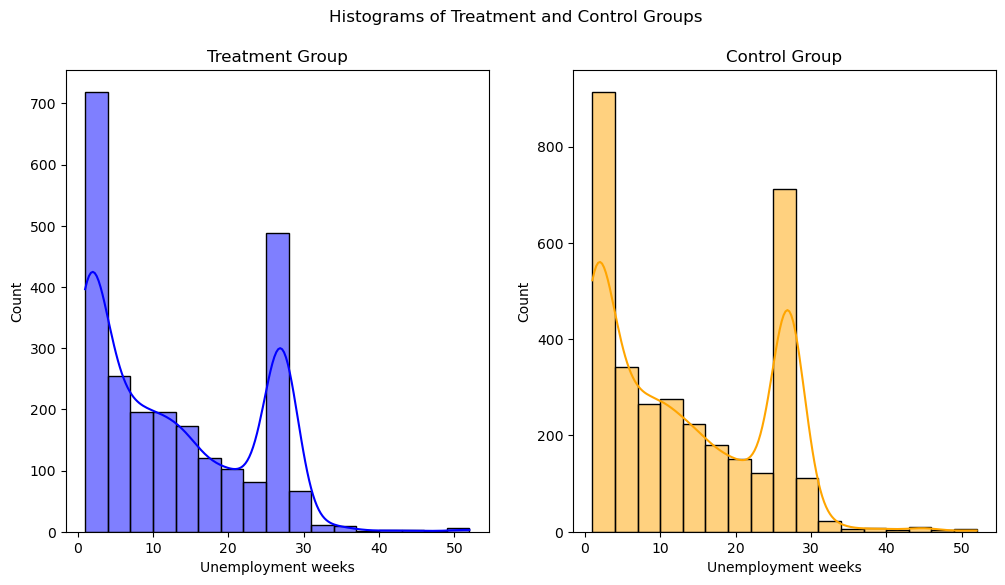

In [7]:
# Plotting histograms for treatment and control groups
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Histogram for the treatment group (left subplot)
sns.histplot(Penn[Penn['T2'] == 1]['inuidur1'], kde=True, color='blue', ax=ax1)
ax1.set_title("Treatment Group")
ax1.set_xlabel("Unemployment weeks")
ax1.set_ylabel("Count")

# Histogram for the control group (right subplot)
sns.histplot(Penn[Penn['T2'] == 0]['inuidur1'], kde=True, color='orange', ax=ax2)
ax2.set_title("Control Group")
ax2.set_xlabel("Unemployment weeks")
ax2.set_ylabel("Count")

# Set a common title for the whole figure
fig.suptitle("Histograms of Treatment and Control Groups")

# Display the plots
plt.show()

### Model 
To evaluate the impact of the treatments on unemployment duration, we consider the linear regression model:

$$
Y =  D \beta_1 + W'\beta_2 + \varepsilon, \quad E \varepsilon (D,W')' = 0,
$$

where $Y$ is  the  log of duration of unemployment, $D$ is a treatment  indicators,  and $W$ is a set of controls including age group dummies, gender, race, number of dependents, quarter of the experiment, location within the state, existence of recall expectations, and type of occupation.   Here $\beta_1$ is the ATE, if the RCT assumptions hold rigorously.


We also consider interactive regression model:

$$
Y =  D \alpha_1 + D W' \alpha_2 + W'\beta_2 + \varepsilon, \quad E \varepsilon (D,W', DW')' = 0,
$$
where $W$'s are demeaned (apart from the intercept), so that $\alpha_1$ is the ATE, if the RCT assumptions hold rigorously.

Under RCT, the projection coefficient $\beta_1$ has
the interpretation of the causal effect of the treatment on
the average outcome. We thus refer to $\beta_1$ as the average
treatment effect (ATE). Note that the covariates, here are
independent of the treatment $D$, so we can identify $\beta_1$ by
just linear regression of $Y$ on $D$, without adding covariates.
However we do add covariates in an effort to improve the
precision of our estimates of the average treatment effect.

### Analysis

We consider 

*  classical 2-sample approach, no adjustment (CL)
*  classical linear regression adjustment (CRA)
*  interactive regression adjusment (IRA)

and carry out robust inference using the *estimatr* R packages. 

## Carry out covariate balance check

This is done using "lm_robust" command which unlike "lm" in the base command automatically does the correct Eicher-Huber-White standard errors, instead othe classical non-robus formula based on the homoscdedasticity command.

In [8]:
formula1 = "T2~(female+black+othrace+C(dep)+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)**2"

model_results = smf.ols(formula1, data = Penn).fit().get_robustcov_results(cov_type = "HC1")


print(model_results.summary())
print( "Number of regressors in the basic model:",len(model_results.params), '\n')

                            OLS Regression Results                            
Dep. Variable:                     T2   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     4.748
Date:                Mon, 01 Jul 2024   Prob (F-statistic):           5.79e-51
Time:                        23:52:13   Log-Likelihood:                -4065.8
No. Observations:                5782   AIC:                             8352.
Df Residuals:                    5672   BIC:                             9084.
Df Model:                         109                                         
Covariance Type:                  HC1                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5090    

C:\Users\Franc\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 119, but rank is 108
  warnings.warn('covariance of constraints does not have full '


## Regress treatment on all covariates using data from R

In [9]:
y = Penn[['T2']].reset_index( drop = True )

In [10]:
# Get data from R
result = pyreadr.read_r('../Documentos/Github/CausalAI-Course/data/m_reg_g2.RData')
X_vars = result['X1']

In [11]:
# model = "T2~(female+black+othrace+C(dep)+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)**2"

model_results = sm.OLS( y, X_vars ).fit().get_robustcov_results(cov_type = "HC1")

print(model_results.summary())
print( "Number of regressors in the basic model:",len(model_results.params), '\n')

                            OLS Regression Results                            
Dep. Variable:                     T2   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                     4.204
Date:                Mon, 01 Jul 2024   Prob (F-statistic):           2.42e-39
Time:                        23:52:13   Log-Likelihood:                -4075.6
No. Observations:                5782   AIC:                             8357.
Df Residuals:                    5679   BIC:                             9043.
Df Model:                         102                                         
Covariance Type:                  HC1                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
(Intercept)              0.5171 

C:\Users\Franc\anaconda3\Lib\site-packages\statsmodels\base\model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 102, but rank is 101
  warnings.warn('covariance of constraints does not have full '


We see that that even though this is a randomized experiment, balance conditions are failed.

# Model Specification

### Classical 2-sample approach, no adjustment (CL)

In [12]:
# model specifications
# take log of inuidur1
Penn["log_inuidur1"] = np.log( Penn["inuidur1"] ) 
log_inuidur1 = pd.DataFrame(np.log( Penn["inuidur1"] ) ).reset_index( drop = True )

# No adjustment (2-sample approach)
formula_cl = 'log_inuidur1 ~ T2'

ols_cl = smf.ols( formula = formula_cl, data = Penn ).fit().get_robustcov_results(cov_type = "HC1")

print(ols_cl.summary())
print( "Number of regressors in the control model:",len(ols_cra.params), '\n')

                            OLS Regression Results                            
Dep. Variable:           log_inuidur1   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     5.879
Date:                Mon, 01 Jul 2024   Prob (F-statistic):             0.0154
Time:                        23:52:13   Log-Likelihood:                -9344.7
No. Observations:                5782   AIC:                         1.869e+04
Df Residuals:                    5780   BIC:                         1.871e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0568      0.021     98.158      0.0

NameError: name 'ols_cra' is not defined

In [ ]:
# Adding controls

formula_cra = 'log_inuidur1 ~ T2 + (female+black+othrace+C(dep)+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)**2'
# Omitted dummies: q1, nondurable, muld

ols_cra = smf.ols( formula = formula_cra, data = Penn ).fit().get_robustcov_results(cov_type = "HC1")

print(ols_cra.summary())
print( "Number of regressors in the control model:",len(ols_cra.params), '\n')

## Model Specification using data from R.

In [ ]:
# model specifications
# take log of inuidur1

log_inuidur1 = pd.DataFrame(np.log( Penn["inuidur1"] ) ).reset_index( drop = True )

# no adjustment (2-sample approach)
formula_cl = 'log_inuidur1 ~ T2'

# adding controls
# formula_cra = 'log_inuidur1 ~ T2 + (female+black+othrace+dep+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)**2'
# Omitted dummies: q1, nondurable, muld

ols_cl = smf.ols( formula = formula_cl, data = Penn ).fit().get_robustcov_results(cov_type = "HC1")

#getting data
# Get data from R
result = pyreadr.read_r('../Documentos/Github/CausalAI-Course/data/ols_ira_reg_g2.RData')
X_vars = result['S1']

ols_cra = sm.OLS( log_inuidur1, X_vars ).fit().get_robustcov_results(cov_type = "HC1")

# Results 
print(ols_cl.summary())
print(ols_cra.summary())
print( "Number of regressors in the interactive model:",len(ols_cra.params), '\n')

In [ ]:
# create Y variable 
log_inuidur1 = pd.DataFrame(np.log( Penn["inuidur1"] )).reset_index( drop = True )

In [ ]:
# Reset index to estimation
# Get data from R
result = pyreadr.read_r('ols_ira_reg_g2.RData')
X_vars = result['S1']

# Interactive regression adjustment (IRA)
ols_ira = sm.OLS( log_inuidur1, X_vars ).fit().get_robustcov_results(cov_type = "HC1")

# Results 
print(ols_ira.summary())

## Next we try out partialling out with lasso

Next we try out partialling out with lasso

In [ ]:
# Get data from R
result = pyreadr.read_r('../Documentos/Github/CausalAI-Course/data/rlasso_ira_reg_g2.RData')
X_vars = result['S']
X_vars

In [ ]:
result = hdmpy.rlassoEffects( X_vars, log_inuidur1, index = 0 )       

rlasso_ira = pd.DataFrame(np.array( (result.res['coefficients'][0] , result.res['se'][0] , \
           result.res['t'][0] , result.res['pval'][0] ) ).reshape(1, 4) , columns = ['Coef.' , \
                            "Std.Err." , "t" , 'P>|t|'] , index = ['T2'])

In [ ]:
# result.res is a object dictionary

result.res.keys()

In [ ]:
result.res['coefficients']

In [ ]:
rlasso_ira

### Results

In [ ]:
table2 = np.zeros((2, 4))
table2[0,0] = ols_cl.summary2().tables[1]['Coef.']['T2']
table2[0,1] = ols_cra.summary2().tables[1]['Coef.']['T2']
table2[0,2] = ols_ira.summary2().tables[1]['Coef.']['T2']
table2[0,3] = rlasso_ira['Coef.']['T2']

table2[1,0] = ols_cl.summary2().tables[1]['Std.Err.']['T2']
table2[1,1] = ols_cra.summary2().tables[1]['Std.Err.']['T2']
table2[1,2] = ols_ira.summary2().tables[1]['Std.Err.']['T2']
table2[1,3] = rlasso_ira['Std.Err.']['T2']

table2 = pd.DataFrame(table2, columns = ["CL", "CRA", "IRA", "IRA Lasso"], \
                      index = ["estimate","standard error"])

table2

Treatment group 4 experiences an average decrease of about $7.5\%$ in the length of unemployment spell.


Observe that regression estimators delivers estimates that are slighly more efficient (lower standard errors) than the simple 2 mean estimator, but essentially all methods have very similar standard errors. From IRA results we also see that there is not any statistically detectable heterogeneity.  We also see the regression estimators offer slightly lower estimates -- these difference occur perhaps to due minor imbalance in the treatment allocation, which the regression estimators try to correct.

## Plotting the coefficients

In [ ]:
# Results 
ols_ira.summary2()

In [ ]:
err_series1 = ols_ira.params[104] - ols_ira.conf_int()[104,0]
coef_df1 = pd.DataFrame({'coef': ols_ira.params[104],
                        'err': err_series1,
                        'varname': ['T2*Female']
                      })
coef_df1

In [ ]:
err_series2 = ols_ira.params[105] - ols_ira.conf_int()[105,0]
coef_df2 = pd.DataFrame({'coef': ols_ira.params[105],
                        'err': err_series2,
                        'varname': ['T2*Black']
                      })
coef_df2

In [ ]:
err_series3 = ols_ira.params[114] - ols_ira.conf_int()[114,0]
coef_df3 = pd.DataFrame({'coef': ols_ira.params[114],
                        'err': err_series3,
                        'varname': ['T2*agelt35']
                      })
coef_df3

In [ ]:
err_series4 = ols_ira.params[107] - ols_ira.conf_int()[107,0]
coef_df4 = pd.DataFrame({'coef': ols_ira.params[107],
                        'err': err_series4,
                        'varname': ['T2*factor(dep)1']
                      })
coef_df4

In [ ]:
table = pd.concat([coef_df1,coef_df2,coef_df3,coef_df4])
table

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
table.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=False)
ax.set_ylabel('')
ax.set_xlabel('')
ax.scatter(x=np.arange(table.shape[0]), 
        marker='s', s=120, 
        y=table['coef'], color='black')
plt.title('Interval confidence')